# Using two spatial weights matrices

Some functions are using spatial weights for two different purposes. Therefore two matrices have to be passed. We will illustrate this case measuring building adjacency and mean interbuilding distance. 

In [1]:
import momepy
import geopandas as gpd
import matplotlib.pyplot as plt

We will again use `osmnx` to get the data for our example and after preprocessing of building layer will generate tessellation. 

In [2]:
import osmnx as ox

gdf = ox.footprints.footprints_from_place(place='Kahla, Germany')
gdf_projected = ox.project_gdf(gdf)

buildings = momepy.preprocess(gdf_projected, size=30,
                              compactness=True, islands=True)
buildings['uID'] = momepy.unique_id(buildings)
limit = momepy.buffered_limit(buildings)
tessellation = momepy.Tessellation(buildings, unique_id='uID', limit=limit).tessellation

Loop 1 out of 2.


Changing geometry: 100%|██████████| 31/31 [00:00<00:00, 89.11it/s]


Loop 2 out of 2.


Changing geometry: 100%|██████████| 2/2 [00:00<00:00, 81.45it/s]


Inward offset...
Discretization...


  2%|▏         | 45/2521 [00:00<00:05, 442.62it/s]

Generating input point array...


100%|██████████| 2521/2521 [00:04<00:00, 624.67it/s]


Generating Voronoi diagram...
Generating GeoDataFrame...


Vertices to Polygons: 100%|██████████| 267595/267595 [00:07<00:00, 37249.46it/s]


Dissolving Voronoi polygons...
Preparing limit for edge resolving...


  0%|          | 0/371 [00:00<?, ?it/s]

Building R-tree...
Identifying edge cells...


 25%|██▍       | 59/238 [00:00<00:00, 579.83it/s]

Cutting...


100%|██████████| 238/238 [00:00<00:00, 449.51it/s]


## Building adjacency

Building adjacency is using `spatial_weights_higher` to denote the area within which the calculation occurs (required) and `spatial_weights` to denote adjacency of buildings (optional, the function can do it for us). We can use distance band of 200 meters to define `spatial_weights_higher`.

In [3]:
import libpysal
dist200 = libpysal.weights.DistanceBand.from_dataframe(buildings, 200,
                                                       ids='uID')

/Users/martin/anaconda3/envs/momepy_guide/lib/python3.7/site-packages/libpysal/weights/weights.py:165: UserWarning: The weights matrix is not fully connected: 
 There are 7 disconnected components.
 There are 2 islands with ids: 324, 575.
  warnings.warn(message)


In [4]:
adjac = momepy.BuildingAdjacency(
    buildings, spatial_weights_higher=dist200, unique_id='uID')
buildings['adjacency'] = adjac.series

  0%|          | 0/2518 [00:00<?, ?it/s]

Calculating spatial weights...
Spatial weights ready...
Calculating adjacency within k steps...


100%|██████████| 2518/2518 [00:00<00:00, 6350.07it/s]


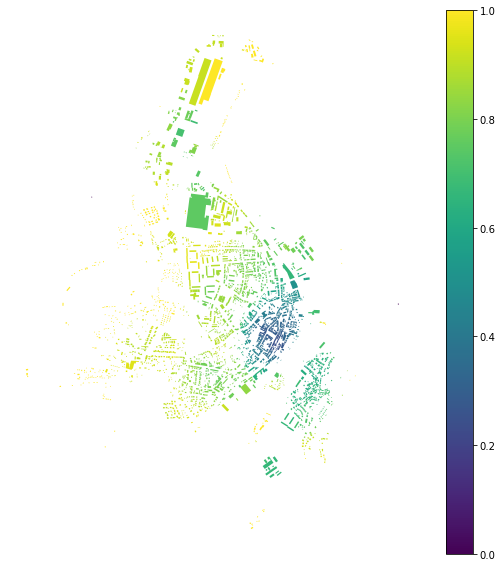

In [5]:
f, ax = plt.subplots(figsize=(10, 10))
buildings.plot(ax=ax, column='adjacency', legend=True, cmap='viridis')
ax.set_axis_off()
plt.show()

If we want to specify or reuse `spatial_weights`, we can generate them as Queen contiguity weights. Using `libpysal` or `momepy` (momepy will use the same libpysal method, but you don't need to import libpysal directly):

In [6]:
queen = libpysal.weights.Queen.from_dataframe(buildings,
                                              silence_warnings=True,
                                              ids='uID')
queen = momepy.sw_high(k=1, gdf=buildings, ids='uID', contiguity='queen')

In [7]:
buildings['adj2'] = momepy.BuildingAdjacency(buildings,
                                             spatial_weights_higher=dist200,
                                             unique_id='uID',
                                             spatial_weights=queen).series

 32%|███▏      | 812/2518 [00:00<00:00, 8119.62it/s]

Calculating adjacency within k steps...


100%|██████████| 2518/2518 [00:00<00:00, 7597.36it/s]


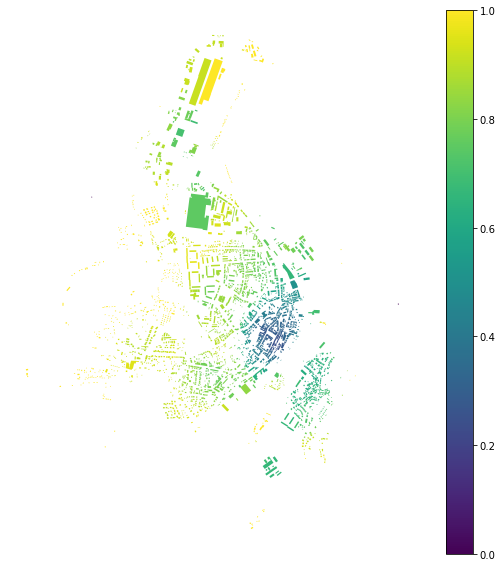

In [8]:
f, ax = plt.subplots(figsize=(10, 10))
buildings.plot(ax=ax, column='adj2', legend=True, cmap='viridis')
ax.set_axis_off()
plt.show()

Both results are the same:

In [9]:
(buildings.adjacency == buildings.adj2).all()

True

## Mean interbuilding distance

Mean interbuilding distance is similar to `neighbour_distance`, but it is calculated within vicinity defined in `spatial_weights_higher`, while `spatial_weights` captures immediate neighbours.

In [10]:
sw1 = momepy.sw_high(k=1, gdf=tessellation, ids='uID')
sw3 = momepy.sw_high(k=3, gdf=tessellation, ids='uID')

In [11]:
interblg_distance = momepy.MeanInterbuildingDistance(
    buildings, sw1, 'uID', spatial_weights_higher=sw3)
buildings['mean_ib_dist'] = interblg_distance.series

  0%|          | 0/14584 [00:00<?, ?it/s]/Users/martin/Strathcloud/Personal Folders/momepy/momepy/momepy/distribution.py:652: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  (adj_list.neighbor == row.focal)
  0%|          | 11/14584 [00:00<02:15, 107.80it/s]

Generating adjacency matrix based on weights matrix...
Computing interbuilding distances...


  0%|          | 0/2518 [00:00<?, ?it/s]/Users/martin/Strathcloud/Personal Folders/momepy/momepy/momepy/distribution.py:674: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  adj_list.neighbor.isin(neighbours)
  2%|▏         | 38/2518 [00:00<00:06, 364.08it/s]

Computing mean interbuilding distances...


 12%|█▏        | 291/2518 [00:00<00:05, 425.46it/s]/Users/martin/Strathcloud/Personal Folders/momepy/momepy/momepy/distribution.py:676: RuntimeWarning: Mean of empty slice
  results_list.append(np.nanmean(selection.distance))
100%|██████████| 2518/2518 [00:06<00:00, 419.63it/s]


`spatial_weights_higher` is optional and can be derived from `spatial_weights` as weights of higher order defined in `order`.

In [12]:
buildings['mean_ib_dist'] = momepy.MeanInterbuildingDistance(
    buildings, sw1, 'uID', order=3).series

Generating weights matrix (Queen) of 3 topological steps...


  0%|          | 21/14584 [00:00<01:12, 201.47it/s]

Generating adjacency matrix based on weights matrix...
Computing interbuilding distances...


  1%|▏         | 36/2518 [00:00<00:07, 340.61it/s]

Computing mean interbuilding distances...


100%|██████████| 2518/2518 [00:05<00:00, 447.42it/s]


/Users/martin/anaconda3/envs/momepy_guide/lib/python3.7/site-packages/mapclassify/classifiers.py:320: RuntimeWarning: invalid value encountered in greater
  binIds += (x > l) * (x <= r) * k
/Users/martin/anaconda3/envs/momepy_guide/lib/python3.7/site-packages/mapclassify/classifiers.py:320: RuntimeWarning: invalid value encountered in less_equal
  binIds += (x > l) * (x <= r) * k


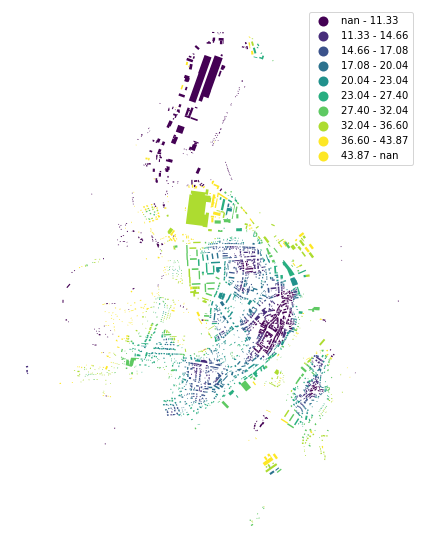

In [13]:
f, ax = plt.subplots(figsize=(10, 10))
buildings.plot(ax=ax, column='mean_ib_dist', scheme='quantiles', k=10, legend=True, cmap='viridis')
ax.set_axis_off()
plt.show()